The idead behind this project is to build a recommender system model that media companies such as Netflix or amazon prime can use to recommend movies to their user that are more likely to be watched by them. as we know we have three main model for recommende systems, collaborative filtering, content-based filtering, and hybrid models that combine both approaches. In this project we have implemented Collaborative filtering that uses the preferences of a group of users to make recommendations for those users. To build this recommender system, we train our model on the ratings data in the ml-20m dataset. The ml-20m dataset contains over 20 million ratings of movies by users, as well as additional information such as movie titles and user demographics. In the case of the predicting user ratings based on the ratings.csv file in the ml-20m dataset, we have taken the following steps:
1.   Loading data
2.   Data cleaning and EDA. However there is no need to data cleaning in this dataset. data preparation
3. Building NN
4. Building model and compiling it
5. Split the data and fit.
6. Plot the train test loss
7. testing the model prediction with comparing the result with actual ratings



In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In case the link for our dataset changes in the future, I got my data from: https://grouplens.org/datasets/movielens/

I used !Wget command-line tool to access data, that makes it possible to download files and interact with REST APIs.

In [3]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2023-05-13 01:30:26--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  3.23MB/s    in 29s     

2023-05-13 01:30:57 (6.60 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



### Unziping the data

In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [5]:
# TO see what we have
!ls

ml-20m	ml-20m.zip  sample_data


In [6]:
# The main directory is ml-20m file that contains multiple .csv files
# we care about rating.csv file as we will use it in our project
df = pd.read_csv('ml-20m/ratings.csv') 
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


Each datapoint is a triple, consist of userId, movie and rating. We are not intrested in timestamp.

Instead of doing random train test, we will do some cut-off type

In [12]:
# if we have n userId, i prefer it to be from 0 to (n-1)
# and if I have m movie, i prefer my movieId to be from 0 to (m-1)
# if these numbers are not sorted as we want, our embedding matrix will be not efficient.
# As we are not sure that userId is continuesly going from 1 to the end or is going to jump. while we will use matrix multiplication. 
# So we create a new column as categorical userId

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

## converting user IDs, movie IDs and ratings in separate numpy arrays
this will be helpful in later steps

In [13]:
user_ids = df['new_user_id'].values
movie_ids = df['movieId'].values
ratings = df['rating'].values

## We need to know the number of user and number of movies

In [14]:
N = len(set(user_ids))
M = len(set(movie_ids))

# We set our embedding dimension to 10, however we can change this hyper parameter later
K = 10
print(f"We have {N} users")
print(f"We have {M} moives")

We have 138493 users
We have 26744 moives


## Building our Neural Network

In [15]:
# User input
# Since the input is just a simple integer, the shape is 1
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N,K)(u) # output is (num_samples, 1 , K)

# Movie embedding
m_emb = Embedding(M,K)(m) # output is (num_samples, 1 , K)

# At this point we flatten both embeddings
u_emb = Flatten()(u_emb) # now it is (num_samples, K)
m_emb = Flatten()(m_emb) # now it is (num_samples, K)

# Now we create our feature vector by concatenating u_emb and m_emb
x = Concatenate()([u_emb, m_emb]) # now it is (num_samples, 2K)

# Now we have feature vector that we can pass it through the NN,
# One approach is to go deep, with many layers, but less units per layer.
# Other approach is to go wide, with less layers with more units.
# So, we go with a single layer with 1024 units
#  we need a regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation = 'relu')(X)
# x = Dense(400, activation = 'relu')(X)
x = Dense(1)(x) # last layer has just 1 unit since we are doing regression

## Building the Model and Compiling it

In [16]:
from scipy.optimize import optimize
# This model does not have 1 input and insted it has 2 inputs. we pass them as a list
model = Model(inputs=[u,m], outputs=x)
model.compile(loss='mse', optimizer=SGD(learning_rate=0.08, momentum=0.9),)
# Since we are doing the regression, the loss is mse and we choose the SGD optimizer.

## Spliting Data

In [17]:
user_ids,movie_ids,ratings = shuffle(user_ids,movie_ids, ratings)
Ntrain = int(0.8 *len(ratings))

train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# Center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

r = model.fit(
    x=[train_user, train_movie],
    y = train_ratings,
    epochs = 25,
    batch_size = 1024,
    validation_data = ([test_user, test_movie], test_ratings),
)

Epoch 1/25
15626/15626 [==============================] - 97s 6ms/step - loss: 0.7825 - val_loss: 0.7340
Epoch 2/25
15626/15626 [==============================] - 78s 5ms/step - loss: 0.7201 - val_loss: 0.7202
Epoch 3/25
15626/15626 [==============================] - 78s 5ms/step - loss: 0.6992 - val_loss: 0.7032
Epoch 4/25
15626/15626 [==============================] - 79s 5ms/step - loss: 0.6811 - val_loss: 0.6946
Epoch 5/25
15626/15626 [==============================] - 76s 5ms/step - loss: 0.6657 - val_loss: 0.6821
Epoch 6/25
15626/15626 [==============================] - 77s 5ms/step - loss: 0.6511 - val_loss: 0.6732
Epoch 7/25
15626/15626 [==============================] - 77s 5ms/step - loss: 0.6396 - val_loss: 0.6699
Epoch 8/25
15626/15626 [==============================] - 73s 5ms/step - loss: 0.6314 - val_loss: 0.6663
Epoch 9/25
15626/15626 [==============================] - 76s 5ms/step - loss: 0.6241 - val_loss: 0.6643
Epoch 10/25
15626/15626 [==============================

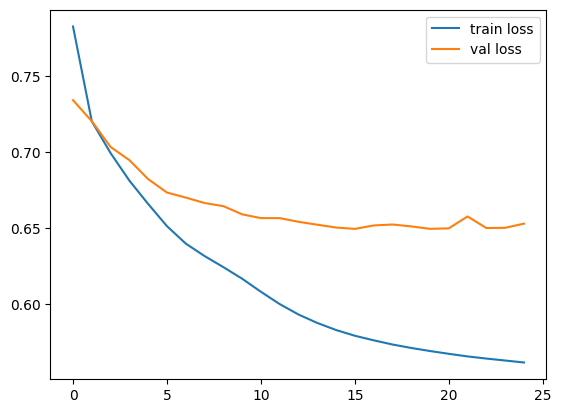

In [18]:
import matplotlib.pyplot as plt

# plot training and validation loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

following code generates a random user ID and a random movie ID from the test set, passes them to the trained model, and gets the predicted rating. Then it adds back the average rating to the prediction, since we had centered the ratings before training. Finally, it prints out the predicted rating for the given user and movie. You can run this code multiple times to get predictions for different user-movie combinations.

In [19]:
Ntest = len(np.unique(test_user))
Mtest = len(np.unique(test_movie))


# generate random user and movie IDs
user_id = np.random.randint(1, Ntest)
movie_id = np.random.randint(1, Mtest)

# predict the rating
pred_rating = model.predict([np.array([user_id]), np.array([movie_id])])[0]

# add back the average rating
pred_rating += avg_rating

print(f"Predicted rating for user {user_id} and movie {movie_id}: {float(pred_rating):.2f}")


1/1 [==============================] - 0s 97ms/step
Predicted rating for user 50474 and movie 5611: 3.43


In [21]:
user_id = 1
movie_id = 858

# Make a prediction for a single user and movie
pred_rating = model.predict([np.array([user_id]), np.array([movie_id])])[0][0]

# Get the actual rating if it exists
actual_rating = test_ratings[(test_user==user_id) & (test_movie==movie_id)]
if len(actual_rating) > 0:
    actual_rating = actual_rating[0]
    print(f"Actual rating for user {user_id} and movie {movie_id}: {actual_rating:.2f}")
else:
    print(f"No actual rating found for user {user_id} and movie {movie_id}.")

# Print out the predicted rating
print(f"Predicted rating for user {user_id} and movie {movie_id}: {pred_rating:.2f}")


1/1 [==============================] - 0s 20ms/step
No actual rating found for user 1 and movie 858.
Predicted rating for user 1 and movie 858: 1.23


This code first checks if there is an actual rating available for the given user_id and movie_id. If a match is found, it prints the actual rating. If not, it prints a message saying that no actual rating was found. After that, it prints the predicted rating.

 Note: the reason i used [0][0] in the end of main line is that; model.predict returns a 2D numpy array where the first dimension corresponds to the number of samples, and the second dimension corresponds to the number of output values for each sample. In this case, we are predicting a single rating, so the array has shape (1, 1).

The [0][0] at the end of the line is used to extract the predicted rating from this array. The first [0] is used to select the first (and only) sample in the array, and the second [0] is used to select the first (and only) output value for that sample

## Printing out the Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix

# Get the predicted ratings for the test set
y_pred = model.predict([test_user, test_movie])

# Convert the ratings to binary values (0 or 1)
y_pred_binary = (y_pred >= test_ratings.mean()).astype(int)
y_true_binary = (test_ratings >= test_ratings.mean()).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_binary, y_pred_binary)

print("Confusion matrix:")
print(conf_matrix)


125002/125002 [==============================] - 222s 2ms/step
Confusion matrix:
[[1419907  581060]
 [ 466740 1532346]]


This code will compute the confusion matrix for the test set, where ratings above test_ratings.mean() are considered positive and ratings below or equal to test_ratings.mean() are considered negative. The confusion_matrix function will return a 2x2 array with the counts of true positives, false positives, false negatives, and true negatives.

# loss on test sets


In [35]:
# Evaluate the model on the test set
test_loss = model.evaluate([test_user, test_movie], test_ratings)

# Print the test accuracy
print(f"Test accuracy: {test_loss:.2%}")

125002/125002 [==============================] - 284s 2ms/step - loss: 0.6527
Test accuracy: 65.27%
